In [25]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from random import shuffle, seed
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

from sklearn.impute import KNNImputer

from scipy.linalg import svd

In [37]:
df = pd.read_csv('data/vehicles.csv')
df = df.drop(columns=['id','VIN'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   title_status  418638 non-null  object 
 10  transmission  424324 non-null  object 
 11  drive         296313 non-null  object 
 12  size          120519 non-null  object 
 13  type          334022 non-null  object 
 14  paint_color   296677 non-null  object 
 15  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 52.1+ MB


In [19]:
df.tail()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
426875,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,NaN,sedan,NaN,wy
426876,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,fwd,NaN,sedan,red,wy
426877,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,NaN,NaN,hatchback,white,wy
426878,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,NaN,sedan,silver,wy
426879,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,rwd,NaN,coupe,NaN,wy


In [38]:
df = df.convert_dtypes()
df.dtypes

region          string
price            Int64
year             Int64
manufacturer    string
model           string
condition       string
cylinders       string
fuel            string
odometer         Int64
title_status    string
transmission    string
drive           string
size            string
type            string
paint_color     string
state           string
dtype: object

In [39]:
df.isna().sum().sort_values(ascending=True)

region               0
price                0
state                0
year              1205
transmission      2556
fuel              3013
odometer          4400
model             5277
title_status      8242
manufacturer     17646
type             92858
paint_color     130203
drive           130567
condition       174104
cylinders       177678
size            306361
dtype: int64

In [42]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
imputer = KNNImputer()

def encode_imputer(df, columns, fill=False):
    for column in columns:
        if fill:
            # fill NaN with 0
            df[column].fillna('0', inplace=True)
        # encode
        df[column] = enc.fit_transform(df[[column]])
        # imputer
        df[column] = imputer.fit_transform(df[[column]]).ravel()

cols_to_fill = ['size','cylinders','condition','drive','paint_color','type','manufacturer', True]

encode_imputer(df, cols_to_fill)
        
df.isna().sum().sort_values(ascending=True)

region             0
price              0
manufacturer       0
condition          0
cylinders          0
drive              0
size               0
type               0
paint_color        0
state              0
year            1205
transmission    2556
fuel            3013
odometer        4400
model           5277
title_status    8242
dtype: int64

In [58]:
# set NaN values in 'odometer' to an average # miles of new cars: 'less than 100 miles'
# src: https://www.caranddriver.com/auto-loans/a31543493/how-many-miles-should-a-new-car-have/
import random

count = 0
for index, row in df.iterrows():
    if pd.isna(row['odometer']):
        df['odometer'][index] = random.randint(49, 101)

In [56]:
df.isna().sum().sort_values(ascending=True)

region             0
price              0
manufacturer       0
condition          0
cylinders          0
odometer           0
drive              0
size               0
type               0
paint_color        0
state              0
year            1205
transmission    2556
fuel            3013
model           5277
title_status    8242
dtype: int64

In [59]:
cols_to_fill = ['title_status','model','fuel','transmission']
encode_imputer(df, cols_to_fill)

In [60]:
df.isna().sum().sort_values(ascending=True)

region             0
price              0
manufacturer       0
model              0
condition          0
cylinders          0
fuel               0
odometer           0
title_status       0
transmission       0
drive              0
size               0
type               0
paint_color        0
state              0
year            1205
dtype: int64

In [61]:
#  drop rows w/ NaN 'year'
df = df.dropna()
df.isna().sum().sort_values(ascending=True)

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

In [62]:
df.dtypes

region           string
price             Int64
year              Int64
manufacturer    float64
model           float64
condition       float64
cylinders       float64
fuel            float64
odometer          Int64
title_status    float64
transmission    float64
drive           float64
size            float64
type            float64
paint_color     float64
state            string
dtype: object

In [63]:
cols_to_encode = ['region','state']
encode_imputer(df, cols_to_encode)

df = df.convert_dtypes()
df.dtypes

region          Int64
price           Int64
year            Int64
manufacturer    Int64
model           Int64
condition       Int64
cylinders       Int64
fuel            Int64
odometer        Int64
title_status    Int64
transmission    Int64
drive           Int64
size            Int64
type            Int64
paint_color     Int64
state           Int64
dtype: object

In [67]:
df_2 = df.copy()
df_2.shape

(425675, 16)

In [68]:
df_2.describe()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
count,425675.0,425675.0,425675.0,425675.0,425675.0,425675.0,425675.0,425675.0,425675.0,425675.0,425675.0,425675.0,425675.0,425675.0,425675.0,425675.0
mean,193.913185,75305.642742,2011.235191,19.03899,16548.678908,1.348931,3.280808,2.992518,97226.503668,1.102167,1.347512,1.217022,0.61671,5.537102,4.624631,23.668684
std,117.595465,12199512.603116,9.45212,12.073242,8007.301126,1.404909,2.939882,0.802471,213256.205656,0.719545,0.729963,1.028606,1.053829,4.577816,4.61048,15.175162
min,0.0,0.0,1900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,82.0,5900.0,2008.0,8.0,10909.0,0.0,0.0,3.0,36528.0,1.0,1.0,0.0,0.0,1.0,0.0,9.0
50%,197.0,13900.0,2013.0,15.0,16621.0,1.0,4.0,3.0,84887.0,1.0,1.0,1.0,0.0,5.0,2.0,23.0
75%,290.0,26000.0,2017.0,29.0,23677.0,3.0,6.0,3.0,133000.0,1.0,1.0,2.0,1.0,10.0,10.0,37.0
max,403.0,3736928711.0,2022.0,42.0,29648.0,6.0,8.0,5.0,10000000.0,6.0,3.0,3.0,4.0,13.0,12.0,50.0


In [69]:
ss = StandardScaler()
df_3 = pd.DataFrame(ss.fit_transform(df_2), columns=ss.get_feature_names_out())
df_3.describe()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
count,4.256750e+05,4.256750e+05,4.256750e+05,4.256750e+05,4.256750e+05,425675.000000,4.256750e+05,4.256750e+05,4.256750e+05,4.256750e+05,4.256750e+05,4.256750e+05,4.256750e+05,4.256750e+05,4.256750e+05,4.256750e+05
mean,-2.670743e-17,-7.010699e-19,8.518334e-15,-1.378103e-16,-2.141936e-16,0.000000,-4.727214e-17,8.279302e-17,-4.306573e-18,-7.397957e-17,1.060285e-16,1.111029e-16,-7.618293e-17,-8.306010e-17,8.920280e-17,4.700507e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.648987e+00,-6.172848e-03,-1.176829e+01,-1.576959e+00,-2.066701e+00,-0.960156,-1.115967e+00,-3.729131e+00,-4.559146e-01,-1.531757e+00,-1.846002e+00,-1.183177e+00,-5.852095e-01,-1.209552e+00,-1.003071e+00,-1.559701e+00
25%,-9.516805e-01,-5.689221e-03,-3.422719e-01,-9.143362e-01,-7.043179e-01,-0.960156,-1.115967e+00,9.324000e-03,-2.846275e-01,-1.419887e-01,-4.760680e-01,-1.183177e+00,-5.852095e-01,-9.911074e-01,-1.003071e+00,-9.666257e-01
50%,2.624947e-02,-5.033456e-03,1.867106e-01,-3.345410e-01,9.031904e-03,-0.248366,2.446332e-01,9.324000e-03,-5.786241e-02,-1.419887e-01,-4.760680e-01,-2.109871e-01,-5.852095e-01,-1.173273e-01,-5.692758e-01,-4.406442e-02
75%,8.170972e-01,-4.041612e-03,6.098966e-01,8.250494e-01,8.902287e-01,1.175216,9.249333e-01,9.324000e-03,1.677491e-01,-1.419887e-01,-4.760680e-01,7.612033e-01,3.637123e-01,9.748978e-01,1.165904e+00,8.784969e-01
max,1.778020e+00,3.063121e+02,1.138879e+00,1.901812e+00,1.635924e+00,3.310589,1.605233e+00,2.501628e+00,4.643609e+01,6.806853e+00,2.263800e+00,1.733394e+00,3.210478e+00,1.630233e+00,1.599698e+00,1.735161e+00


In [118]:
all_indicies = list(range(0, len(df_3)))
seed(42)
shuffle(all_indicies)
train_idx, test_idx = np.split(all_indicies, [340540])

X = df_3.drop('price', axis=1)
y = df_3['price']

def feature_selector(X, y, train_idx, test_idx, num_iterations):
    mse_list = []
    num_features_list = []
    data_frames_dict = {}
    
    for num_features in num_iterations:
        selector = SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=num_features,
                                           cv=[[train_idx,test_idx]],
                                           scoring = 'neg_mean_squared_error')
        Xt = selector.fit_transform(X, y)
        lr = LinearRegression().fit(Xt, y)
        model_preds = lr.predict(Xt)
        mse = mean_squared_error(y, model_preds)
        
        data_frame = pd.DataFrame(selector.fit_transform(X, y), 
                                  columns = selector.get_feature_names_out())
        data_frames_dict[num_features] = data_frame
        
        mse_list.append(mse)
        num_features_list.append(num_features)
        
    return data_frames_dict, mse_list, num_features_list

In [119]:
num_features_to_try = [2,4,6,8,10,12,14]
data_frames_dict, mse_list, num_features_list = feature_selector(X,y,train_idx,test_idx,num_features_to_try)

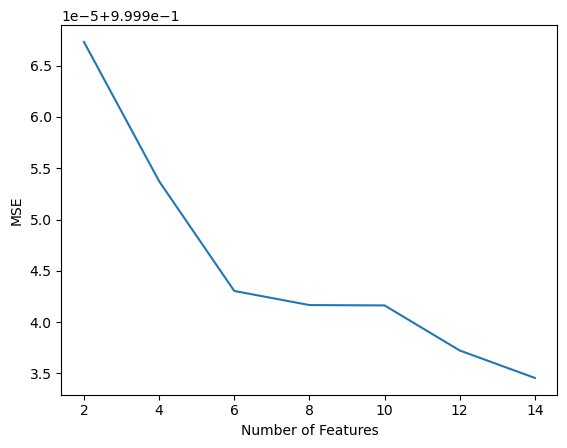

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

mse_list
num_features_list

mse_num_features_plot = sns.lineplot(x=num_features_list, y=mse_list)
mse_num_features_plot.set(xlabel='Number of Features', ylabel='MSE')
plt.show()

In [122]:
# get the data frame created in feature_selector() with 6 features

df_4 = data_frames_dict[6]
df_4

,year,manufacturer,model,condition,drive,type
0,0.292507,-0.334541,0.973153,1.175216,-1.183177,0.756453
1,-0.130679,-0.914336,1.023232,1.175216,-1.183177,0.756453
2,0.927286,-0.914336,1.029102,1.175216,-1.183177,0.756453
3,0.609897,1.736156,1.411379,1.175216,-1.183177,0.756453
4,0.186711,-0.417369,-0.254228,-0.248366,1.733394,1.193343
...,...,...,...,...,...,...
425670,0.821490,1.073533,0.401050,1.175216,0.761203,0.974898
425671,0.927286,1.901812,0.884859,1.175216,0.761203,0.974898
425672,0.927286,-0.997164,1.596085,1.175216,-1.183177,-0.117327
425673,0.715693,0.410910,-0.383236,1.175216,0.761203,0.974898


In [129]:
# evaluating model performance

lr = LinearRegression().fit(df_4.iloc[train_idx], df_3.iloc[train_idx]['price'])

train_predict = lr.predict(df_4.iloc[train_idx])
dev_predict = lr.predict(df_4.iloc[test_idx])

mse_train = mean_squared_error(df_3.iloc[train_idx]['price'], lr.predict(df_4.iloc[train_idx]))
mse_test = mean_squared_error(df_3.iloc[test_idx]['price'], lr.predict(df_4.iloc[test_idx]))

print(f'Training MSE {mse_train} Development MSE {mse_test}')

Training MSE 1.0690797424090104 Development MSE 0.7233985097737214


In [142]:
# determine best alpha for Ridge regression

from sklearn.linear_model import Ridge

X = df_4.copy() # data set with 6 features
y = df_3['price'] # only the 'price' column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

params_dict = {'alpha': 1000**np.linspace(-5,5,10)}

grid = GridSearchCV(Ridge(), param_grid=params_dict)
grid.fit(X_train, y_train)

train_mse = mean_squared_error(y_train, grid.predict(X_train))
test_mse = mean_squared_error(y_test, grid.predict(X_test))
best_alpha = grid.best_params_


print(f'train_mse {train_mse} test_mse {test_mse} best_alpha {best_alpha}')


train_mse 0.7142458164598184 test_mse 1.6667587818576117 best_alpha {'alpha': 215443469.00318953}


In [143]:
X = df_3.drop('price', axis=1) # data set with 6 features
y = df_3['price'] # only the 'price' column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

params_dict = {'alpha': 1000**np.linspace(-5,5,10)}

grid = GridSearchCV(Ridge(), param_grid=params_dict)
grid.fit(X_train, y_train)

train_mse = mean_squared_error(y_train, grid.predict(X_train))
test_mse = mean_squared_error(y_test, grid.predict(X_test))
best_alpha = grid.best_params_

print(f'train_mse {train_mse} test_mse {test_mse} best_alpha {best_alpha}')

train_mse 0.7142457557426354 test_mse 1.6667587723620532 best_alpha {'alpha': 215443469.00318953}


In [147]:
X = df_3.drop('price', axis=1) # all data
y = df_3['price'] # only the 'price' column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 215443469.00318953 -6.3510533787614065e-06
# 1e-2 9.248412492723901e-06
# 10 9.248990215149355e-06
# 1e+2 9.254190835639164e-06

model = Ridge(alpha=1e+2).fit(X_train, y_train)
model.score(X_test, y_test)

9.254190835639164e-06

In [150]:
X = df_4.copy() # data set with 6 features
y = df_3['price'] # only the 'price' column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1e+2 2.7712896906839646e-05
# 215443469.00318953 -6.3567504353656545e-06
# 1e-2 2.7717504490931688e-05

model = Ridge(alpha=1e-2).fit(X_train, y_train)
model.score(X_test, y_test)

2.7717504490931688e-05

In [ ]:
from sklearn.inspection import permutation_importance

X = df_4.copy() # data set with 6 features
y = df_3['price'] # only the 'price' column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = Ridge(alpha=1e-2).fit(X_train, y_train)
r_score = permutation_importance(model, X_test, y_test, n_reats=30, random_state=0)

for i in r_score.importances_mean.argsort()[::-1]:
...     if r_score.importances_mean[i] - 2 * r_score.importances_std[i] > 0:
...         print(f"{diabetes.feature_names[i]:<8}"
...               f"{r.importances_mean[i]:.3f}"
...               f" +/- {r.importances_std[i]:.3f}")

